<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from geometry import find_max_dist_brute, find_max_dist

In [140]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [141]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [142]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

In [166]:
g1 = G1()
g2 = G2()

In [307]:
class MCMCSolver: 
    def __init__(self, dataset,lmbd,beta = 0.1):
        self.dataset = dataset
        self.state = np.random.binomial(1, 0.1, dataset.N).astype(bool) #randomly initialize state
        self.lmbd = lmbd
        self.beta = beta
               
    #code from solvers 
    def dist(self,pt1: np.ndarray, pt2: np.ndarray) -> np.float:
        return np.linalg.norm(pt1 - pt2, ord=2)
    
    def objective(self):
#         mask = self.dataset.x[self.state]
#         return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(find_max_dist_brute(mask)/2)**2
        return (self.state*self.dataset.v).sum() - self.lmbd*self.dataset.N*np.pi*(self.radius(self.state)/2)**2
        
    #compute the radius of the state
    #direct computation, probably more clever way to compute radius difference
    def radius(self,state):
        best = 0
        for k,i in enumerate(state):
            if i > 0:
                for l,j in enumerate(state):
                    if j > 0:
                        best = np.maximum(best,self.dist(self.dataset.x[k],self.dataset.x[l]))
        return best
    
    def compute_diff(self,state_1,state_2,i):
#         mask_1 = self.dataset.x[state_1]
#         mask_2 = self.dataset.x[state_2]
        diff = (int(state_2[i]) - int(state_1[i]))*self.dataset.v[i] \
        - self.lmbd*self.dataset.N*np.pi*((self.radius(state_2)/2)**2-(self.radius(state_1)/2)**2)
#         - self.lmbd*self.dataset.N*np.pi*((find_max_dist_brute(mask_2)/2)**2-(find_max_dist_brute(mask_1)/2)**2)
        return diff

    def acceptance_proba(self,diff,beta):
        proba = np.exp(beta*diff)
        return np.minimum(1.0,proba)
    
    def solve(self,n_it):
        print("Initial state:",self.state)
        n_states = []
        objectives = []
        for it in range(n_it):
            next_state = self.state.copy()
            
            #flip one state at random
            i = np.random.choice(self.dataset.N)
            next_state[i] = True^next_state[i]
                        
            #update state with acceptance probability
            diff = self.compute_diff(self.state, next_state,i)
            if np.random.uniform() < self.acceptance_proba(diff, self.beta):
                self.state = next_state
            
            #record number of states and objective for plotting, as per project description
            if (it % 5) == 0:
                n_states.append(self.state.sum())
                objectives.append(self.objective())
                
            #beta scheduling    
            if ((it % 500) == 0) and (it > 0):
                self.beta = self.beta*10  
        
        print("Final state:",self.state)
        return n_states,objectives

In [308]:
mcmc = MCMCSolver(dataset = g2, lmbd = 2,beta = 1)
n_states, objectives = mcmc.solve(n_it = 2000)

Initial state: [False  True False False False False False False False False False False
 False False False  True False  True False False False False False False
 False False  True False False False False  True False False  True False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
  True  True False False False False False False False False False False
 False False False False  True  True False False False False False False
  True False  True False False False False False  True False False False
 False False False False]
Final state: [ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False  True  True  True  True  True  True
 False  True  True  True  True  True  True  True False  True  True  Tr

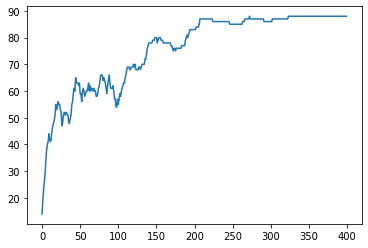

In [309]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_states) 

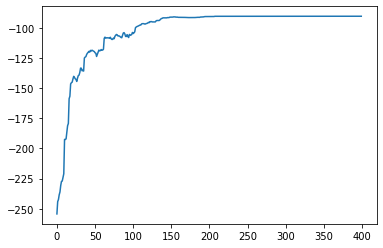

In [310]:
plt.plot(objectives)